# Procesamiento de Imágenes
## Trabajo Practico 4 - Análisis frecuencial

In [1]:
import cv2
from PIL import Image
import os   
import numpy as np
import matplotlib.pyplot as plt
from skimage import data

In [ ]:

img_high = cv2.imread('./img/city.jpg')
img_low = cv2.imread('./img/beach.jpg')

img_high = cv2.cvtColor(img_high, cv2.COLOR_BGR2GRAY)
img_low = cv2.cvtColor(img_low, cv2.COLOR_BGR2GRAY)

# Resize to the same size
width = 768
height = 1440

img_high = cv2.resize(img_high, (width, height))
img_low = cv2.resize(img_low, (width, height))

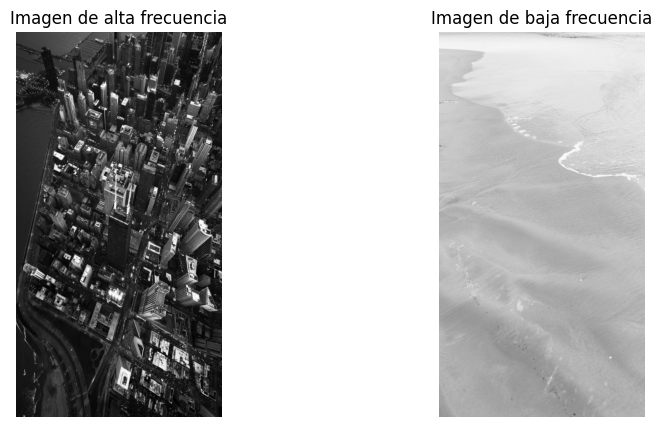

In [ ]:
# mostrar las imagenes
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img_high, cmap='gray')
plt.suptitle('Imagen de alta frecuencia')
plt.axis('off')
plt.subplot(122)
plt.imshow(img_low, cmap='gray')
plt.suptitle('Imagen de baja frecuencia')
plt.axis('off')
plt.show()

### 10. (*) Responder las siguientes preguntas. Tratar de utilizar dos imágenes en aquellos ejercicios que no soliciten algo particular. Utilizar una imagen que muestre frecuencias bajas en su mayoría y otras con mayoría de frecuencias altas. Por cada pregunta se ha agregado una sugerencia de como realizar el ejercicio practico para acompañar su respuesta

#### (a) ¿Cómo se visualiza la diferencia entre las frecuencias altas y bajas en una imagen? Ejercicio sugerido: Aplicar la Transformada de Fourier (DFT) y mostrar la magnitud del espectro centrado con fftshift

Al aplicar la DFT a una imagen y visualizar la magnitud del espectro, podemos observar que la mayoría de la energía de la imagen se concentra en el centro del espectro. Esto se debe a que las frecuencias bajas (que corresponden a las áreas homogéneas de la imagen) están cerca del origen. 
En este ejemplo en particular, la imagen de la izquierda tiene un espectro con gran presencia de frecuencias altas, mientras que la imagen de la derecha tiene un espectro con predominancia de frecuencias bajas, por lo que se puede observar que la mayoría de la energía está concentrada en el centro del espectro.

In [29]:
# Helper
def normalize(img):
    img = img - img.min()
    return img / img.max()


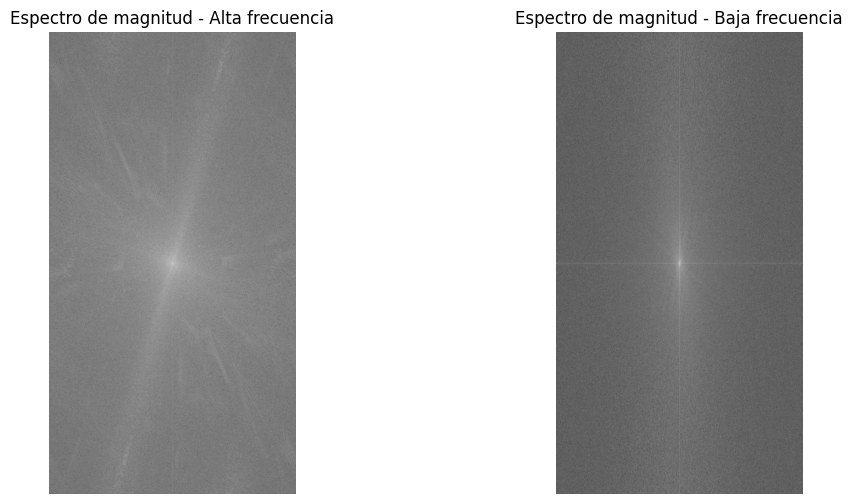

In [ ]:
# Fourier analysis
fourier_high = np.fft.fft2(img_high)
fourier_low = np.fft.fft2(img_low)

# Shift the zero frequency component to the center
fourier_high_shifted = np.fft.fftshift(fourier_high)
fourier_low_shifted = np.fft.fftshift(fourier_low)

# Calculate the magnitude spectrum
mag_high = np.abs(fourier_high_shifted) 
mag_low = np.abs(fourier_low_shifted)

spect_high = np.log(mag_high)/ 20
spect_low = np.log(mag_low)/ 20



# Use same scale for both to highlight differences
vmin = 0
vmax = max(spect_high.max(), spect_low.max())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(spect_high, cmap='gray', vmin=vmin, vmax=vmax)
plt.suptitle('Espectro de magnitud - Alta frecuencia')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spect_low, cmap='gray', vmin=vmin, vmax=vmax)
plt.suptitle('Espectro de magnitud - Baja frecuencia')
plt.axis('off')

plt.show()

#### ¿Qué ocurre si eliminamos las componentes de alta frecuencia de una imagen? ¿Y si eliminamos las de baja frecuencia? Ejercicio sugerido: Aplicar filtros pasa bajos y pasa altos en el dominio de la frecuencia y reconstruir la imagen con la transformada inversa

Si eliminamos las componentes de alta frecuencia, la imagen resultante se verá más suave y con menos detalles, ya que las frecuencias altas son responsables de los bordes y los detalles. Por otro lado, si eliminamos las componentes de baja frecuencia, se pierde la información de fondo o estructura general de la imagen, por lo que el resultado se asemeja a un mapa de bordes, en el que solo las transiciones abruptas son visibles.

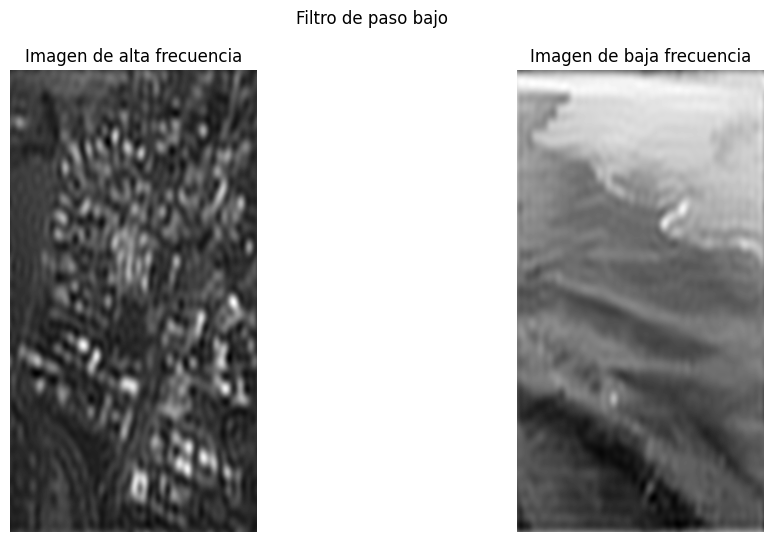

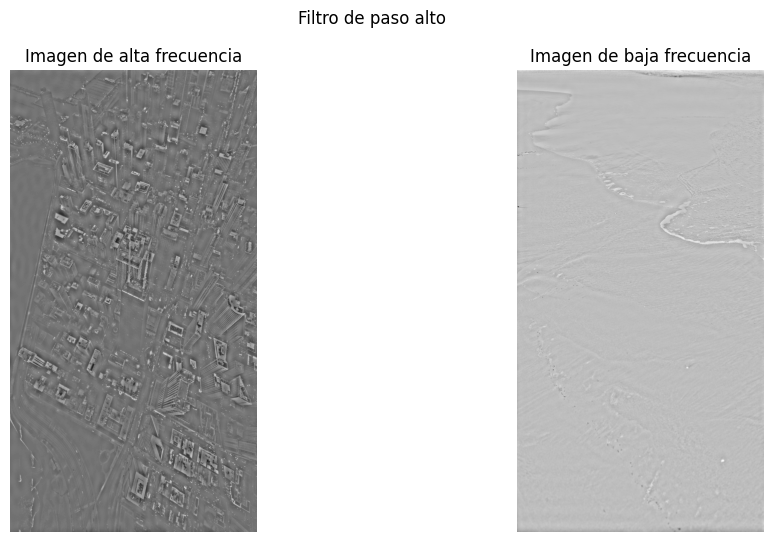

In [37]:
## Flitros de alta y baja frecuencia en analisis de Fourier
def low_pass_filter(shape, radius):
    mask = np.zeros(shape, dtype=np.float32)
    cy, cx = shape[0] // 2, shape[1] // 2
    cv2.circle(mask, (cx, cy), radius, 1, thickness=-1)[0]
    cv2.GaussianBlur(mask, (0, 0), 10)

    return mask

def high_pass_filter(shape, radius):
    low_pass = low_pass_filter(shape, radius)
    return 1 - low_pass

def apply_filter(fourier, mask):
    return fourier * mask

def inverse_transform(fourier):
    return np.fft.ifft2(np.fft.ifftshift(fourier)).real




hpf_high = apply_filter(fourier_high_shifted, high_pass_filter(img_high.shape, 30))
lpf_high = apply_filter(fourier_high_shifted, low_pass_filter(img_high.shape, 30))
hpf_low = apply_filter(fourier_low_shifted, high_pass_filter(img_low.shape, 30))
lpf_low = apply_filter(fourier_low_shifted, low_pass_filter(img_low.shape, 30))

# inversas
img_high_hpf = inverse_transform(hpf_high)
img_high_lpf = inverse_transform(lpf_high)

img_low_hpf = inverse_transform(hpf_low)
img_low_lpf = inverse_transform(lpf_low)


# show
plt.figure(figsize=(12, 6))
plt.suptitle('Filtro de paso bajo')
plt.subplot(1, 2, 1)
plt.imshow(img_high_lpf, cmap='gray')
plt.title('Imagen de alta frecuencia')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_low_lpf, cmap='gray')
plt.title('Imagen de baja frecuencia')
plt.axis('off')
plt.show()


plt.figure(figsize=(12, 6))
plt.suptitle('Filtro de paso alto')
plt.subplot(1, 2, 1)
plt.imshow(img_high_hpf, cmap='gray')
plt.title('Imagen de alta frecuencia')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_low_hpf, cmap='gray')
plt.title('Imagen de baja frecuencia')
plt.axis('off')
plt.show()


#### ¿Qué representa la fase de la transformada de Fourier de una imagen? ¿Qué ocurre si se conserva solo la fase o solo la magnitud? Ejercicio sugerido: Reconstruir una imagen usando solo la magnitud y fase de otra imagen, intercambiar fase y magnitud entre dos imágenes distintas.

La  fase de una frecuencia en particular nos dice dónde están ubicadas espacialmente las características que generan esa frecuencia (es decir, codifica la información de la posición de los detalles en la imagen). Si intercambiamos la fase y la magnitud entre dos imágenes, obtendremos una imagen que tiene la estructura de una imagen (la fase) pero con la textura de otra (la magnitud). Esto provoca que la imagen resultante sea mucho más parecida a la imagen de la que se tomó la fase, como se verá en el siguiente ejemplo.

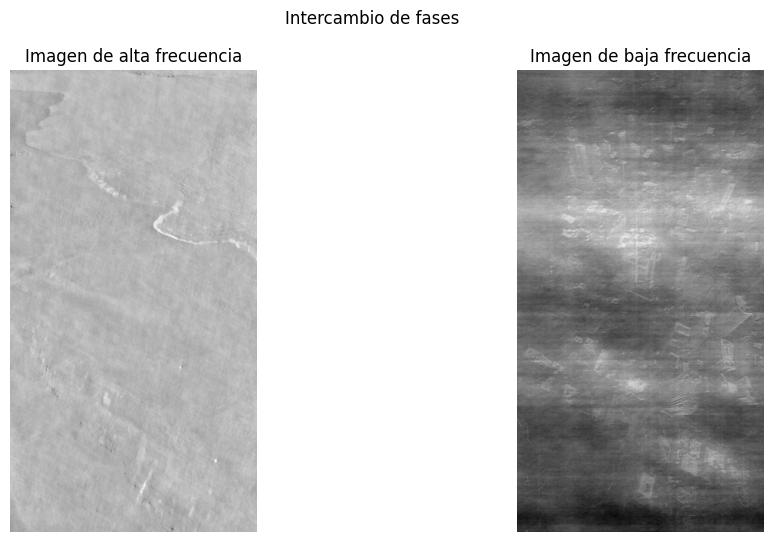

In [38]:
fase_high = np.angle(fourier_high_shifted)
fase_low = np.angle(fourier_low_shifted)

# intercambiar fases y reconstruir usando la inversa
fourier_high_shifted_new = mag_high * np.exp(1j * fase_low)
fourier_low_shifted_new = mag_low * np.exp(1j * fase_high)
img_high_new = inverse_transform(fourier_high_shifted_new)
img_low_new = inverse_transform(fourier_low_shifted_new)
plt.figure(figsize=(12, 6))
plt.suptitle('Intercambio de fases')
plt.subplot(1, 2, 1)
plt.imshow(img_high_new, cmap='gray')
plt.title('Imagen de alta frecuencia')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_low_new, cmap='gray')
plt.title('Imagen de baja frecuencia')
plt.axis('off')
plt.show()


#### Por qué se centra la transformada de Fourier para su visualización? ¿Qué efecto tiene? Ejercicio sugerido: Mostrar el espectro de magnitud con y sin aplicar fftshift

La transformada de Fourier se centra para su visualización principalmente por razones de conveniencia. Al centrar la transformada, las frecuencias bajas quedan en el centro y las altas en la periferia, lo que se alinea con nuestra intuición sobre mayor distancia al centro = mayor magnitud.
Además, al realizar esta operación se hacen evidentes las simetrías que pueden existir en el espectro, y se facilita la aplicación de operaciones como los filtros de frecuencia.

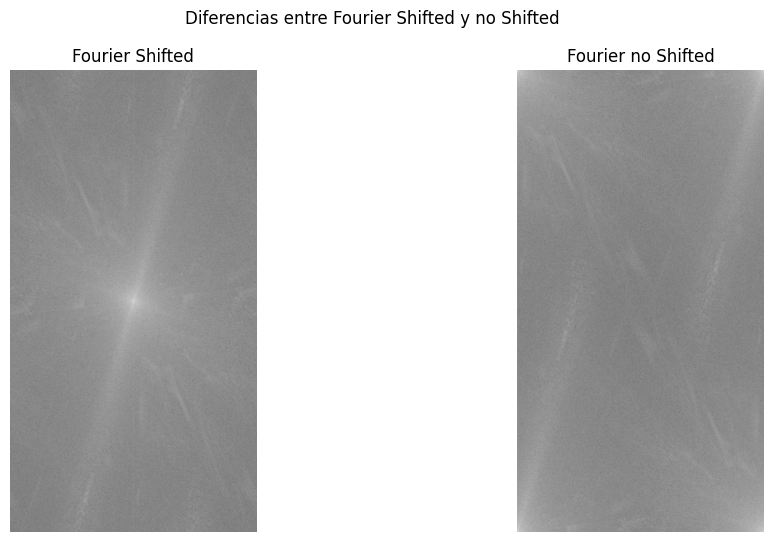

In [41]:
shifted = fourier_high_shifted
unshifted = fourier_high

# Mostrar las diferencias entre las dos
plt.figure(figsize=(12, 6))
plt.suptitle('Diferencias entre Fourier Shifted y no Shifted')
plt.subplot(1, 2, 1)
plt.imshow(np.log(np.abs(shifted)) / 20, cmap='gray')
plt.title('Fourier Shifted')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.log(np.abs(unshifted)) / 20, cmap='gray')
plt.title('Fourier no Shifted')
plt.axis('off')
plt.show()

#### (e) ¿Cómo se comporta la transformada de Fourier ante la traslación o rotación de una imagen? Ejercicio sugerido: Aplicar una traslación o rotación y comparar los espectros de magnitud y fase antes y después.

Una traslación de la imagen provoca un desfase lineal en el espectro de fase, mientras que la magnitud permanece inalterada. Intuitivamente, esto se debe a que la "forma" de los objetos presentes en la imagen (codificada por la magnitud) no cambia, pero su posición (codificada por la fase) sí.

Una rotación en el dominio espacial provoca una rotación idéntica en el espectro de Fourier, tanto en la magnitud como en la fase. Esto se debe a que la rotación de la imagen afecta a todas las frecuencias de manera uniforme, lo que provoca que el espectro también rote.

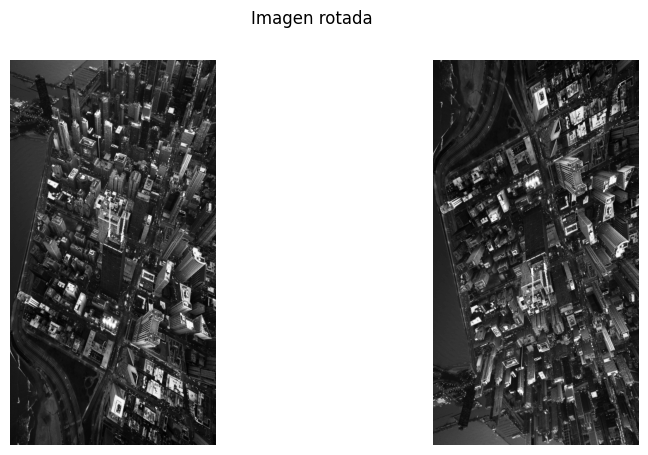

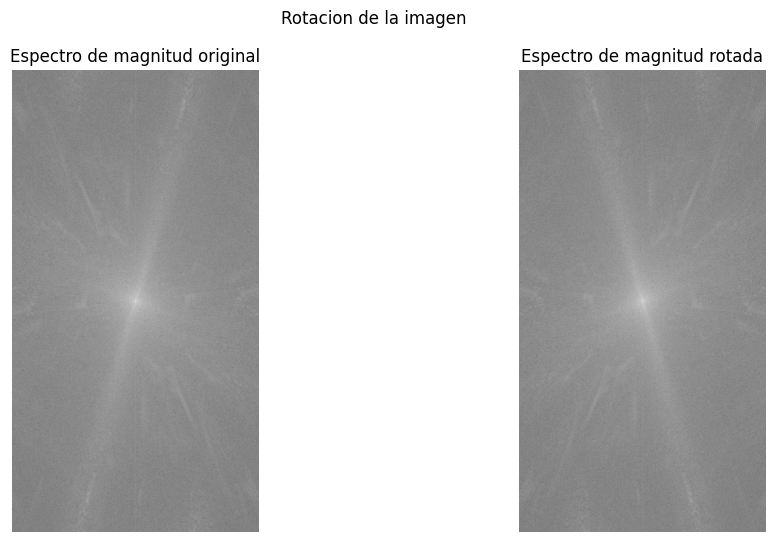

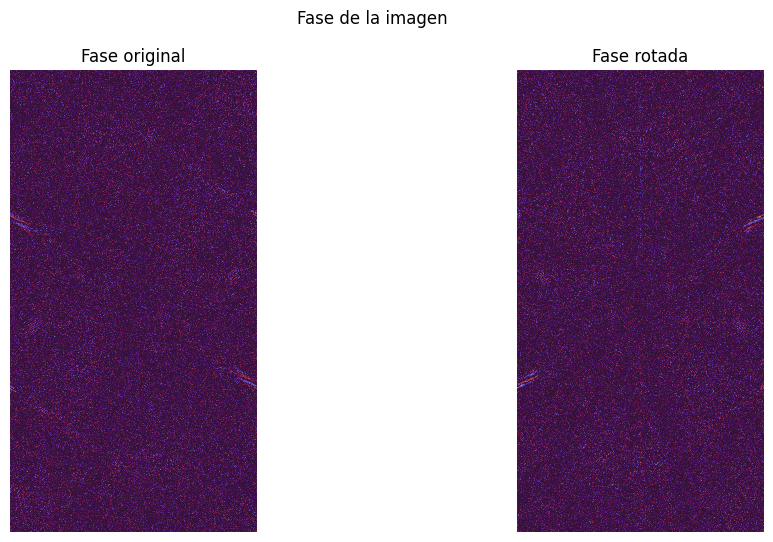

In [45]:
mag_original = mag_high
fase_original = np.angle(fourier_high_shifted)


# Trasladar la imagen: invertida con respecto al eje x
img_rotated = cv2.flip(img_high, 0)

img_rotated = cv2.resize(img_rotated, (width, height))
# Mostrar la imagen rotada
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img_high, cmap='gray')
plt.suptitle('Imagen original')
plt.axis('off')
plt.subplot(122)
plt.imshow(img_rotated, cmap='gray')    
plt.suptitle('Imagen rotada')
plt.axis('off')
plt.show()

# Transformada de Fourier
fourier_rotated = np.fft.fft2(img_rotated)
fourier_rotated_shifted = np.fft.fftshift(fourier_rotated)
mag_rotated = np.abs(fourier_rotated_shifted)
fase_rotated = np.angle(fourier_rotated_shifted)


# normalizar y mostrar
plt.figure(figsize=(12, 6))
plt.suptitle('Rotacion de la imagen')
plt.subplot(1, 2, 1)
plt.imshow(np.log(mag_original) / 20, cmap='gray')
plt.title('Espectro de magnitud original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.log(mag_rotated) / 20, cmap='gray')
plt.title('Espectro de magnitud rotada')
plt.axis('off')
plt.show()


# mostrar la fase
plt.figure(figsize=(12, 6))
plt.suptitle('Fase de la imagen')
plt.subplot(1, 2, 1)
plt.imshow(fase_original, cmap='twilight', vmin=-np.pi, vmax=np.pi)
plt.title('Fase original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(fase_rotated, cmap='twilight', vmin=-np.pi, vmax=np.pi)
plt.title('Fase rotada')
plt.axis('off')
plt.show()

#### (f) ¿Cómo se refleja una estructura periódica en el dominio frecuencial? Ejercicio sugerido: Usar imágenes sintéticas (rejillas, lı́neas) y observar cómo se representan sus frecuencias dominantes.

- **Líneas verticales** generan picos en la frecuencia horizontal (eje x), como se ve en la magnitud (primer fila, centro).

- **Líneas horizontales** generan picos en la frecuencia vertical (eje y), como se observa en la segunda fila.

- **Una rejilla** genera una combinación de frecuencias horizontales y verticales, produciendo una cuadrícula de picos en la magnitud (tercera fila, centro).

Esto demuestra que las estructuras periódicas en la imagen producen componentes dominantes en frecuencias específicas del dominio de Fourier.

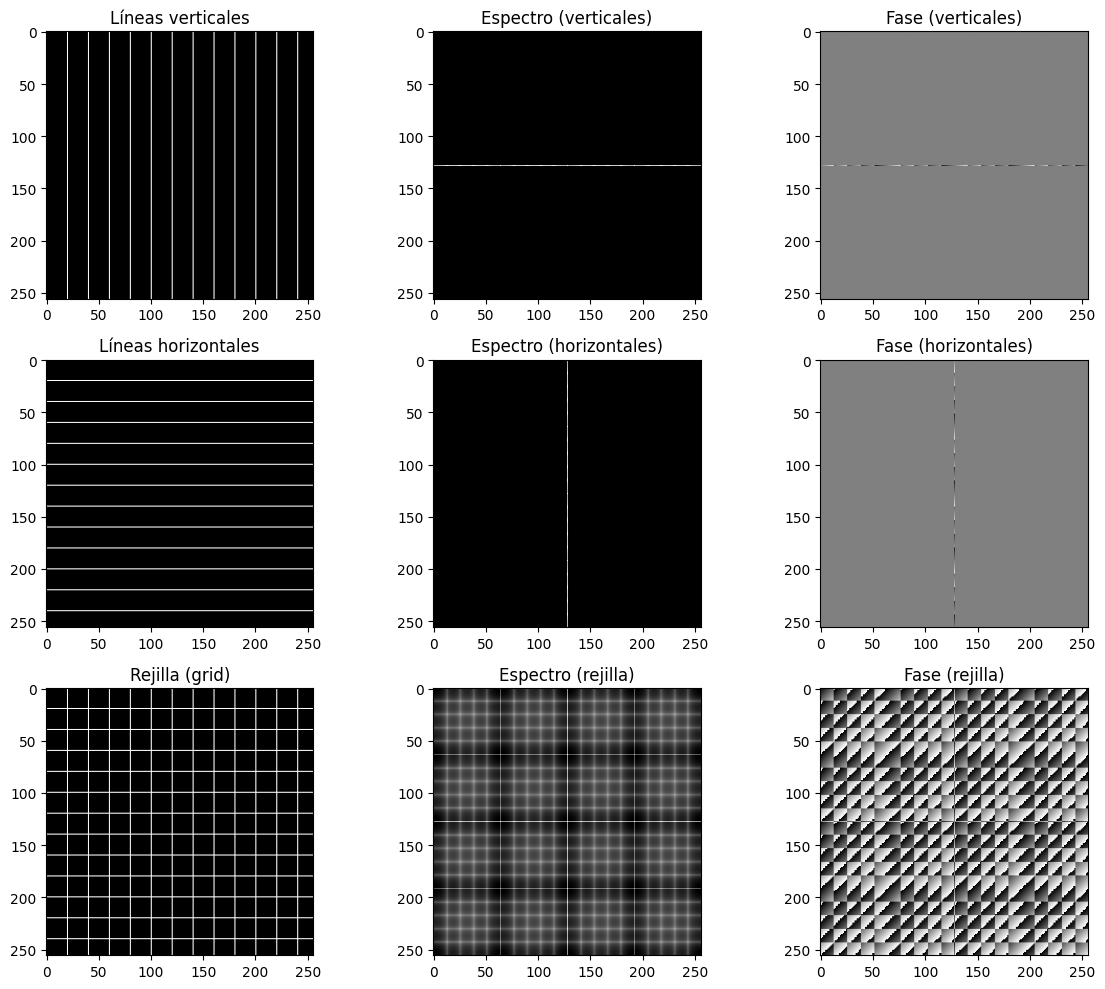

In [6]:
# Create a image with vertical lines
img_vertical = np.zeros((256, 256), dtype=np.uint8)
img_vertical[:, ::20] = 255 

# Create image with horizontal lines
img_horizontal = np.zeros((256, 256), dtype=np.uint8)
img_horizontal[::20, :] = 255 

# create image with grates
img_grid = np.clip(img_vertical + img_horizontal, 0, 255)



def compute_spectrum(img):
    fourier = np.fft.fft2(img)
    f_transform = np.fft.fftshift(fourier)
    mag = np.abs(f_transform)
    fase = np.angle(f_transform)
    return mag,fase

mag_vertical, fase_vertical  = compute_spectrum(img_vertical)
mag_horizontal, fase_horizontal = compute_spectrum(img_horizontal)
mag_grid, fase_grid = compute_spectrum(img_grid)

#plot
plt.figure(figsize=(12, 10))

plt.subplot(331), plt.imshow(img_vertical, cmap='gray'), plt.title('Líneas verticales')
plt.subplot(332), plt.imshow(np.log1p(mag_vertical), cmap='gray'), plt.title('Espectro (verticales)')
plt.subplot(333), plt.imshow(fase_vertical, cmap='gray', vmin=-np.pi, vmax=np.pi), plt.title('Fase (verticales)')

plt.subplot(334), plt.imshow(img_horizontal, cmap='gray'), plt.title('Líneas horizontales')
plt.subplot(335), plt.imshow(np.log1p(mag_horizontal), cmap='gray'), plt.title('Espectro (horizontales)')
plt.subplot(336), plt.imshow(fase_horizontal, cmap='gray', vmin=-np.pi, vmax=np.pi), plt.title('Fase (horizontales)')

plt.subplot(337), plt.imshow(img_grid, cmap='gray'), plt.title('Rejilla (grid)')
plt.subplot(338), plt.imshow(np.log1p(mag_grid), cmap='gray'), plt.title('Espectro (rejilla)')
plt.subplot(339), plt.imshow(fase_grid, cmap='gray', vmin=-np.pi, vmax=np.pi), plt.title('Fase (rejilla)')

plt.tight_layout()
plt.show()

#### (g) ¿Qué diferencias se observan en el espectro de imágenes suaves vs. imágenes con bordes pronunciados? Ejercicio sugerido: Comparar el espectro de una imagen desenfocada vs. la original con bordes definidos.

Podemos observar que la imagen con bordes pronunciados presenta un espectro de magnitud con una mayor presencia de componentes de alta frecuencia, las cuales se encuentran distribuidas lejos del centro del espectro. Estas componentes están más marcadas en direcciones dominantes, como los ejes horizontal y vertical, así como en las diagonales, lo que refleja la presencia de detalles y cambios abruptos en la imagen. En cambio, en la imagen desenfocada, el espectro muestra una mayor concentración de energía en las frecuencias bajas (cerca del centro), mientras que las altas frecuencias (alejadas del centro) están atenuadas. Esto ocurre porque el desenfoque suaviza los bordes y elimina los detalles finos.


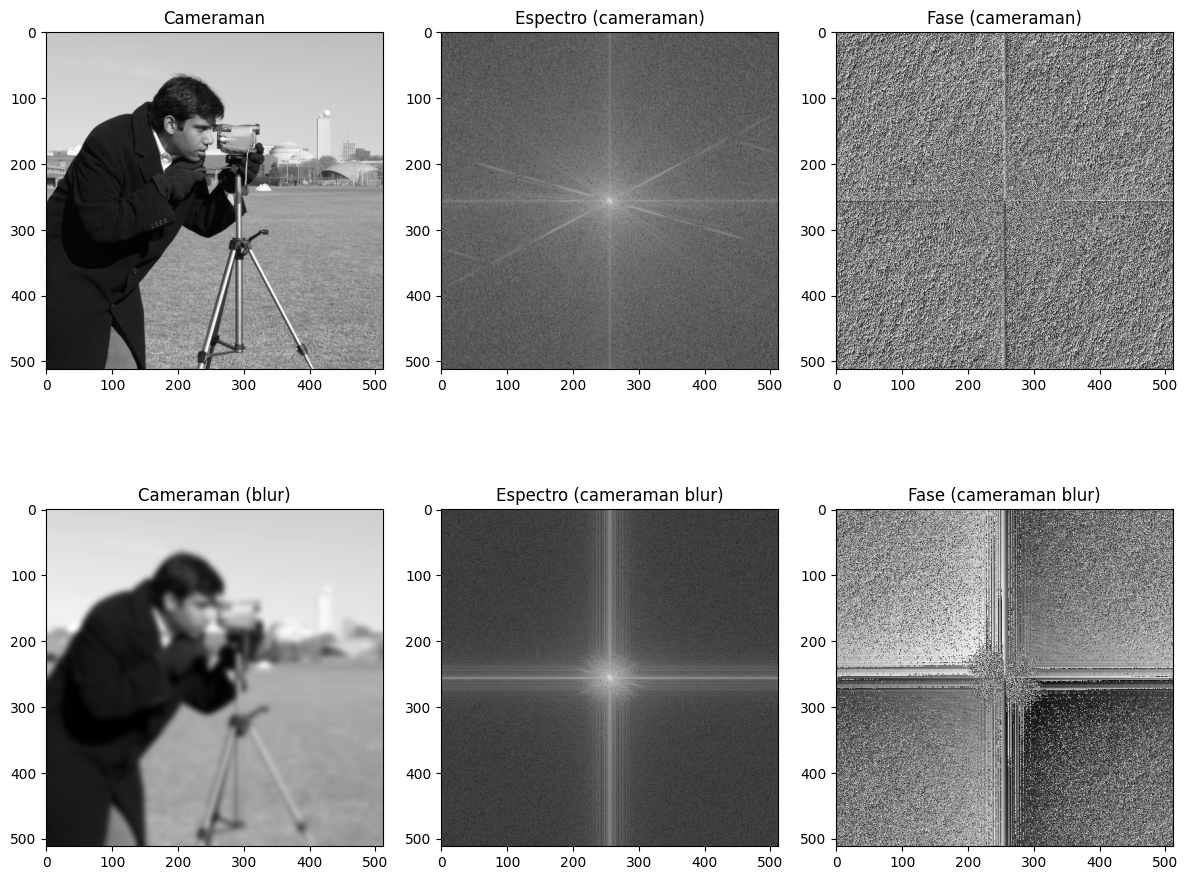

In [5]:
# loada cameraman image
img_cameraman = data.camera()

# Apply blur
img_cameraman_blur = cv2.GaussianBlur(img_cameraman, (25, 25), 0 )

magnitud_cameraman, fase_cameraman = compute_spectrum(img_cameraman)
magnitud_cameraman_blur, fase_cameraman_blur = compute_spectrum(img_cameraman_blur)

#plot
plt.figure(figsize=(12, 10))
plt.subplot(231), plt.imshow(img_cameraman, cmap='gray'), plt.title('Cameraman')
plt.subplot(232), plt.imshow(np.log1p(magnitud_cameraman), cmap='gray'), plt.title('Espectro (cameraman)')
plt.subplot(233), plt.imshow(fase_cameraman, cmap='gray', vmin=-np.pi, vmax=np.pi), plt.title('Fase (cameraman)')

plt.subplot(234), plt.imshow(img_cameraman_blur, cmap='gray'), plt.title('Cameraman (blur)')
plt.subplot(235), plt.imshow(np.log1p(magnitud_cameraman_blur), cmap='gray'), plt.title('Espectro (cameraman blur)')
plt.subplot(236), plt.imshow(fase_cameraman_blur, cmap='gray', vmin=-np.pi, vmax=np.pi), plt.title('Fase (cameraman blur)')
plt.tight_layout()
plt.show()

#### (h) ¿Qué ocurre si aplicamos un filtro de forma circular o rectangular en el espectro? ¿Cómo cambia la imagen? Ejercicio sugerido: Implementar máscaras ideales de paso bajo y paso alto circulares y cuadradas y observar sus efectos.

Podemos observar como en los filtros de paso bajo, tanto el círculo como el cuadrado están centrados y, por lo tanto, dejan pasar las frecuencias bajas (centro del espectro) mientras que eliminan las altas y por eso las imágenes filtradas se ven más suaves y borrosas, ya que se eliminaron los detalles como bordes y texturas. También podemos notar como al ser el cuadrado más grande, este tiene un rango más amplio y deja pasar frecuencias más altas que el círculo por eso la imagen se ve menos nítida.

Para los filtros de paso alto vemos que estos bloquean las frecuencias bajas y dejan pasar las altas y como resultado tenemos que las imágenes son mucho más oscuras y resaltan los contornos, ya que solo conservan las variaciones rápidas de intensidad.

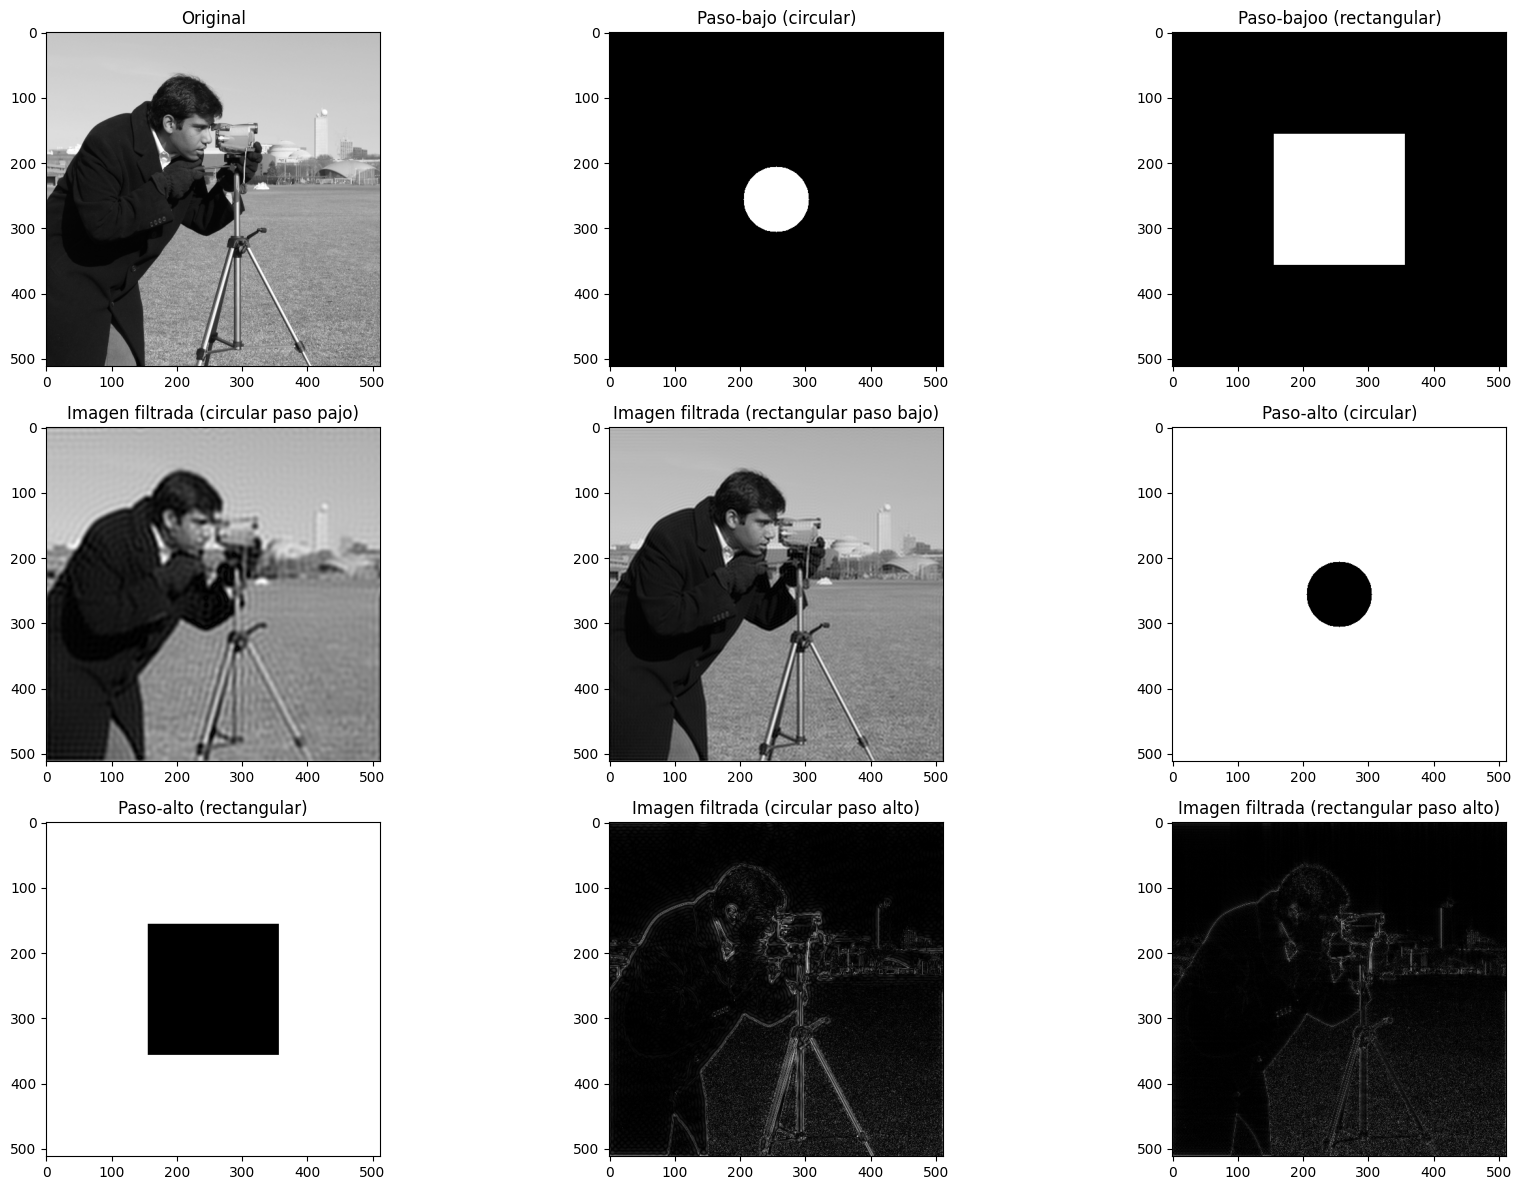

In [33]:
# loada cameraman image
img_cameraman = data.camera()

# Calculate dft and centrate spectrum
dft = np.fft.fft2(img_cameraman)
dft_shifted = np.fft.fftshift(dft)

# Create a mask
rows, cols = img_cameraman.shape
center = (rows // 2, cols // 2)

# Create a circular mask (low-pass filter)
mask_circle_low = np.zeros((rows, cols), dtype=np.uint8)
cv2.circle(mask_circle_low, center, 50 , 1,-1)

# Create a rectangular mask (low-pass filter)
mask_rect_low = np.zeros((rows, cols), dtype=np.uint8)
cv2.rectangle(mask_rect_low, (center[1] - 100, center[0] - 100), (center[1] + 100, center[0] + 100), 1, -1)

# Create masks high-pass filter
mask_circle_high = 1 - mask_circle_low 
mask_rect_high = 1 - mask_rect_low

# Apply filters
filtered_circle_low = dft_shifted * mask_circle_low
filtered_rect_low = dft_shifted * mask_rect_low
filtered_circle_high = dft_shifted * mask_circle_high
filtered_rect_high = dft_shifted * mask_rect_high

# Inverse DFT
img_circle_low = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_circle_low)))
img_rect_low = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_rect_low)))

img_circle_high = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_circle_high)))
img_rect_high = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_rect_high)))


#Plot
plt.figure(figsize=(18, 12))

plt.subplot(331), plt.imshow(img_cameraman, cmap='gray'), plt.title('Original')
plt.subplot(332), plt.imshow(mask_circle_low, cmap='gray'), plt.title('Paso-bajo (circular)')
plt.subplot(333), plt.imshow(mask_rect_low, cmap='gray'), plt.title('Paso-bajoo (rectangular)')
plt.subplot(334), plt.imshow(img_circle_low, cmap='gray'), plt.title('Imagen filtrada (circular paso pajo)')
plt.subplot(335), plt.imshow(img_rect_low, cmap='gray'), plt.title('Imagen filtrada (rectangular paso bajo)')

plt.subplot(336), plt.imshow(mask_circle_high, cmap='gray'), plt.title('Paso-alto (circular)')
plt.subplot(337), plt.imshow(mask_rect_high, cmap='gray'), plt.title('Paso-alto (rectangular)')
plt.subplot(338), plt.imshow(img_circle_high, cmap='gray'), plt.title('Imagen filtrada (circular paso alto)')
plt.subplot(339), plt.imshow(img_rect_high, cmap='gray'), plt.title('Imagen filtrada (rectangular paso alto)')

plt.tight_layout()
plt.show()

#### (i) ¿Cuál es la relación entre el patrón de una imagen (orientación, repetición) y la simetrı́a del espectro? Ejercicio sugerido: Usar imágenes diagonales o repetitivas y analizar la simetrı́a del espectro.

En la imagen en diagonal vemos como el espectro muestra una distribución fuerte a lo largo de la diagonal opuesta. Esto se debe a que la orientación del espacio se refleja como simetría cruzada en el dominio frecuencial. Se mantiene la simetría central del espectro si el patrón está en diagonal, las frecuencias dominantes están alineadas con esa orientación.


En la imagen cuadricular aparecen picos bien definidos y simétricos distribuidos regularmente en el espectro, indicando la repetición en el espacio. La regularidad del patrón se traduce en simetría y periodicidad en el espectro.


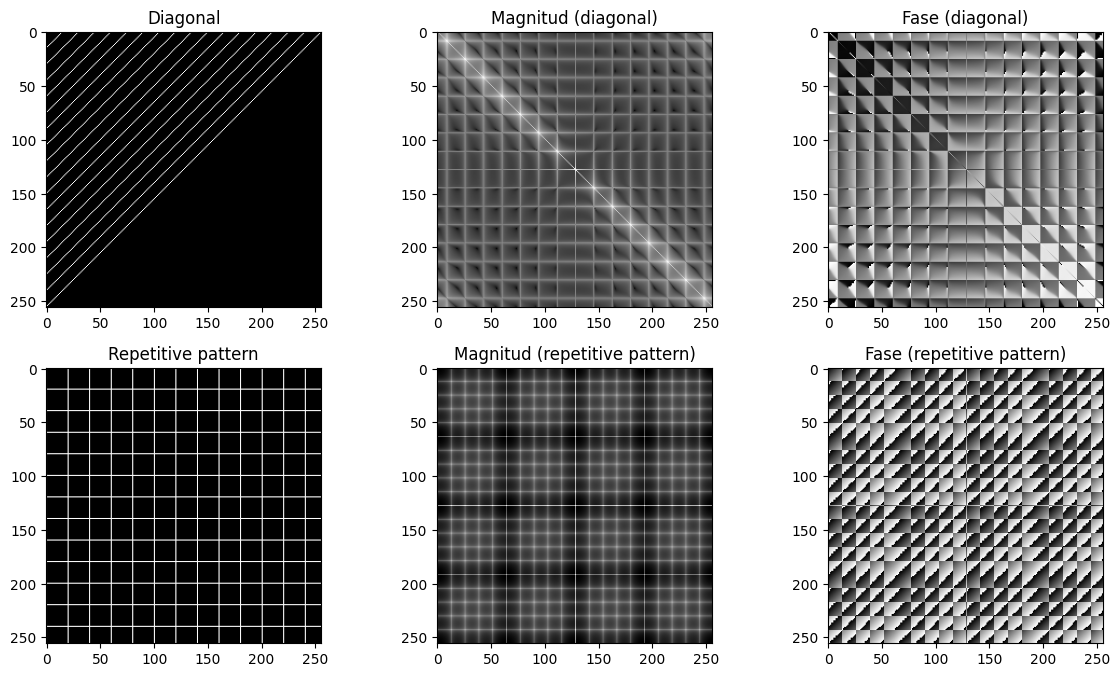

In [38]:
# Create diagonal image
img_diagonal = np.zeros((256, 256), dtype=np.uint8)
for i in range(0, 256, 15):
    cv2.line(img_diagonal, (i, 0), (0, i), 255, 1)

# Create repetitive pattern image
img_grid = np.zeros((256, 256), dtype=np.uint8)
img_grid[::20, :] = 255  
img_grid[:, ::20] = 255  

# Calculate magnitude and phase
mag_diagonal, fase_diagonal = compute_spectrum(img_diagonal)
mag_grid, fase_grid = compute_spectrum(img_grid)

# Plot results
plt.figure(figsize=(12, 10))
plt.subplot(331), plt.imshow(img_diagonal, cmap='gray'), plt.title('Diagonal')
plt.subplot(332), plt.imshow(np.log1p(mag_diagonal), cmap='gray'), plt.title('Magnitud (diagonal)')
plt.subplot(333), plt.imshow(fase_diagonal, cmap='gray', vmin=-np.pi, vmax=np.pi), plt.title('Fase (diagonal)')

plt.subplot(334), plt.imshow(img_grid, cmap='gray'), plt.title('Repetitive pattern')
plt.subplot(335), plt.imshow(np.log1p(mag_grid), cmap='gray'), plt.title('Magnitud (repetitive pattern)')
plt.subplot(336), plt.imshow(fase_grid, cmap='gray', vmin=-np.pi, vmax=np.pi), plt.title('Fase (repetitive pattern)')
plt.tight_layout()
plt.show()

#### (j) ¿Cómo puede usarse el dominio frecuencial para eliminar ruido periódico en una imagen? Ejercicio sugerido: Introducir ruido periódico artificialmente y diseñar un filtro para suprimirlo en el dominio de la frecuencia.

El dominio frecuencial permite aislar y eliminar ruido periódico de manera muy precisa, identificando sus componentes en el espectro y anulándolos sin afectar el resto de la imagen significativamente. Es una técnica muy potente, especialmente cuando el ruido es regular y tiene una firma espectral clara.

Para eliminar el ruido repetitivo es necesario que el espectro sea analizado por un profesional el cual entienda el problema y como interpretarlo, ya que es necesario que el profesional sea capaz de identificar las frecuencias que generan el ruido periodico. Se puede ver un ejemplo a continuación:

![img](./img/inform.png)

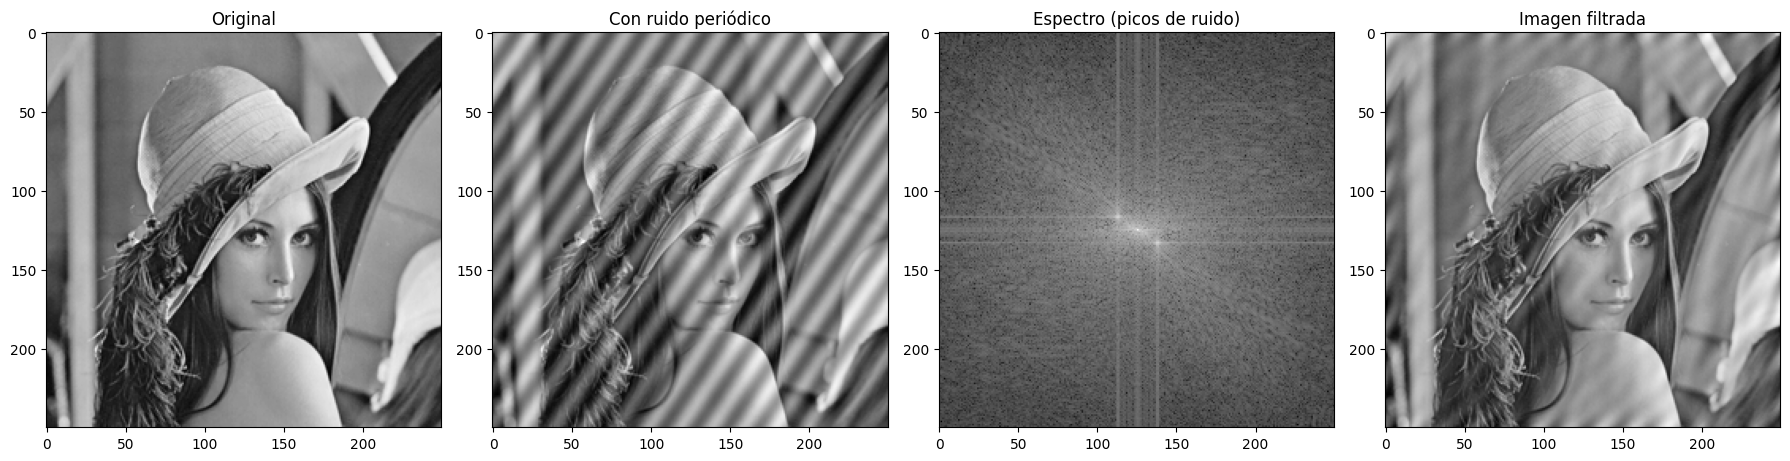

In [ ]:
lenna_image = cv2.imread('../Images/Lenna.png', cv2.IMREAD_GRAYSCALE).astype(float)

# Create artificial periodic noise
rows, cols = lenna_image.shape
x = np.arange(cols)
y = np.arange(rows)
X, Y = np.meshgrid(x, y)
noise_perodic = 50 * np.sin(2 * np.pi * X / 20 + 2 * np.pi * Y / 30)

# Add noise to the image
lenna_image_noisy = cv2.add(lenna_image, noise_perodic)

# Calculate DFT and shift
dft = np.fft.fft2(lenna_image_noisy)
dft_shifted = np.fft.fftshift(dft)
magnitude_lenna = 20 * np.log(np.abs(dft_shifted) + 1)

# Create notch filter
mask = np.ones((rows, cols), dtype=float)
center = (rows // 2, cols // 2)

# Cordenates of the noise
cv2.circle(mask, (center[1] + 15, center[0] + 8), 7, 0, -1)  
cv2.circle(mask, (center[1] - 15, center[0] - 8), 7, 0, -1)  



# Apply notch filter
filtered_dft = dft_shifted * mask

# Inverse DFT
lenna_image_filtered = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_dft)))

# Plot results
plt.figure(figsize=(18, 6))

plt.subplot(141), plt.imshow(lenna_image, cmap='gray'), plt.title('Original')
plt.subplot(142), plt.imshow(lenna_image_noisy, cmap='gray'), plt.title('Con ruido periódico')
plt.subplot(143), plt.imshow(magnitude_lenna, cmap='gray'), plt.title('Espectro (picos de ruido)')
plt.subplot(144), plt.imshow(lenna_image_filtered, cmap='gray'), plt.title('Imagen filtrada')

plt.tight_layout()
plt.show()